# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

### Learning Objectives:

At the end of the experiment, you will be able to:

*  Preprocessing text data
*  Representation of  text document using Bag of Words
*  Understand Bag of Words represented text data with K-nearest neighbours

### Dataset
In this experiment we use the 20 newsgroup dataset

**Description**

This dataset is a collection of approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups. That is there are approximately one thousand documents taken from each of the following newsgroups:

    alt.athesim
    comp.graphics   
    comp.os.ms-windows.misc
    comp.sys.ibm.pc.hardware
    comp.sys.mac.hardware
    comp.windows.x
    misc.forsale
    rec.autos
    rec.motorcycles
    rec.sport.baseball
    rec.sport.hockey
    sci.crypt
    sci.electronics
    sci.med
    sci.space
    soc.religion.christian
    talk.politics.guns
    talk.politics.mideast
    talk.politics.misc
    talk.religion.misc

The dataset consists **Usenet** posts--essentially an email sent by subscribers to that newsgroup. They typically contain quotes from previous posts as well as cross posts i.e. a few posts may be sent to more than once in a newsgroup.

Each newsgroup is stored in a subdirectory, with each post stored as a separate file.

Data source to this experiment : http://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups

### Domain Information
A newsgroup, despite the name, has nothing to do with news. It is what we would call today a mailing list or a discussion forum. *Usenet* is a distributed discussion system designed and developed in 1979 and deployed in 1980.  

Members joined newsgroups of interest to them and made *posts* to them. Posts are very similar to email -- in later years, newsgroups became mailing lists and people posted via email.

The problem that we are attempting is "Text classification". This is a broadly defined task which is common to many services and products: for example, gmail classifies an incoming mail into different sections such as Updates, Forums etc


### Bag of Words (BoW)

* The bag-of-words is a simple to understand representation of documents and words. As you are aware it makes use of the one-hot representation of each word based on the vocabulary and the document is represented as a sum of the BoW vectors of all the words in the document
 
#### Challenges

* The dimension of each vector representing a word is the number of words in the vocabulary. So we definitely will encounter the *curse of dimensionality* 
* Bag of words representation doesn’t consider the semantic relation between words. 
* Nor does it capture the grammar of the language--parts of speech etc., 

#### Keywords

* Numpy
* Collections
* Gensim
* Bag-of-Words (Word Frequency, Pre-Processing)
* Bag-of-Words representation

#### Expected Time : 60 min

### Setup Steps

In [0]:
# Importing required Packages
import pickle
import re
import operator
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import math
import collections
import gensim

In [0]:
# Loading the dataset
dataset = pickle.load(open('AIML_DS_NEWSGROUPS_PICKELFILE.pkl','rb'))
print(type(dataset))
print(dataset.keys())

<class 'dict'>
dict_keys(['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc'])


To get a sense of our data, let us first start by counting the frequencies of the target classes in our news articles in the training set.

In [0]:
# Print frequencies of dataset
print("Class : count")
print("--------------")
number_of_documents = 0
for key in dataset:
    print(key, ':', len(dataset[key]))

Class : count
--------------
talk.politics.mideast : 940
rec.autos : 990
comp.sys.mac.hardware : 961
alt.atheism : 799
rec.sport.baseball : 994
comp.os.ms-windows.misc : 985
rec.sport.hockey : 999
sci.crypt : 991
sci.med : 990
talk.politics.misc : 775
rec.motorcycles : 994
comp.windows.x : 980
comp.graphics : 973
comp.sys.ibm.pc.hardware : 982
sci.electronics : 981
talk.politics.guns : 910
sci.space : 987
soc.religion.christian : 997
misc.forsale : 972
talk.religion.misc : 628


Next, let us split our dataset which consists of  about 1000 samples per class, into training and test sets. We use about 95% samples from each class in the training set, and the remaining  in the test set.





As a mental exercise you should try reasoning about why is it important to ensure a nearly equal distribution of classes in your training and test sets. 

In [0]:
train_set = {}
test_set = {}
new_dataset = {}

# Clean dataset for text encoding issues :- Very useful when dealing with non-unicode characters
for key in dataset:
    new_dataset[key] = [[i.decode('utf-8', errors='replace').lower() for i in f] for f in dataset[key]]
    
# Break dataset into 95-5 split for training and testing
n_train = 0
n_test = 0
for k in new_dataset:
    split = int(0.95*len(new_dataset[k]))
    train_set[k] = new_dataset[k][0:split]
    test_set[k] = new_dataset[k][split:]
    n_train += len(train_set[k])
    n_test += len(test_set[k])

In [0]:
len(new_dataset.values())

20

In [0]:
split

596

In [0]:
train_set.keys()

dict_keys(['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc'])

## 1. Bag-of-Words

Let us begin our journey into text classification with one of the simplest but most commonly used feature representations for news documents - Bag-of-Words.

As you might have realized, machine learning algorithms need good feature representations of different inputs.  Concretely, we would like to represent each news article $D$ in terms of a feature vector $V$, which can be used for classification. Feature vector $V$ is made up of the number of occurences of each word in the vocabulary.

Let us begin by counting the number of occurences of every word in the news documents in the training set.

### 1.1 Word frequency

Let us try understanding the kind of words that appear frequently, and those that occur rarely. We now count the frequencies of words:

In [0]:
# Initialize a dictionary to store frequencies of words.
# Key:Value === Word:Count
frequency = defaultdict(int)
    
for key in train_set:
    for f in train_set[key]:
        
        # Find all words which consist only of capital and lowercase characters and are between length of 2-9.
        # We ignore all special characters such as !.$ and words containing numbers
        words = re.findall(r'(\b[A-Za-z][a-z]{2,9}\b)', ' '.join(f))
    
        for word in words:
            frequency[word] += 1

sorted_words = sorted(frequency.items(), key=operator.itemgetter(1), reverse=True)
print("Top-10 most frequent words:")
for word in sorted_words[:10]:
    print(word)

print('----------------------------')
print("10 least frequent words:")
for word in sorted_words[-10:]:
    print(word)

Top-10 most frequent words:
('the', 226860)
('and', 90621)
('that', 62088)
('for', 43546)
('you', 42430)
('from', 35358)
('this', 31001)
('not', 28645)
('have', 28519)
('are', 28355)
----------------------------
10 least frequent words:
('apokteiuo', 1)
('odessy', 1)
('reedited', 1)
('stumps', 1)
('morsel', 1)
('roston', 1)
('nutball', 1)
('tillage', 1)
('honorably', 1)
('beecher', 1)


Next, we attempt to plot a histogram of the counts of various words in descending order. 

Could you comment about the relationship between the frequency of the most frequent word to the second frequent word? 
And what about the third most frequent word?

(Hint - Check the relative frequencies of the first, second and third most frequent words)

(After answering, you can visit https://en.wikipedia.org/wiki/Zipf%27s_law for further Reading)

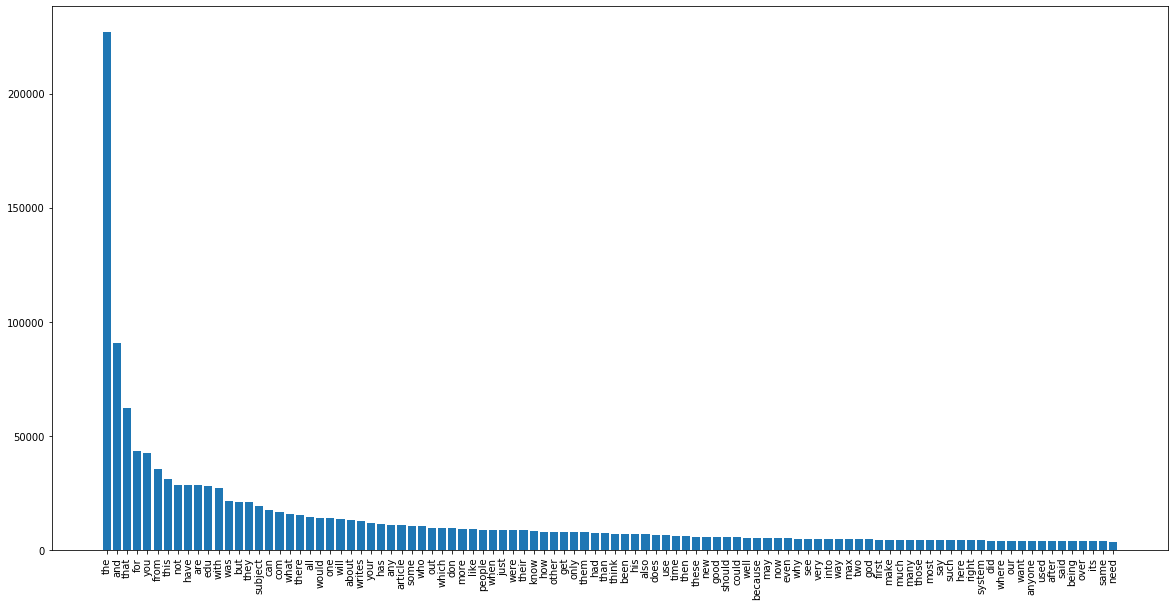

In [0]:
%matplotlib inline  

fig = plt.figure()
fig.set_size_inches(20,10)

plt.bar(range(len(sorted_words[:100])), [v for k, v in sorted_words[:100]] , align='center')
plt.xticks(range(len(sorted_words[:100])), [k for k, v in sorted_words[:100]])
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

### 1.2 Pre-processing to remove most and least frequent words

We can see that different words appear with different frequencies.

The most common words appear in almost all documents. Hence, for a classification task, having information about those words' frequencies does not mater much since they appear frequently in every type of document. To get a good feature representation, we eliminate them since they do not add too much value.

Additionally, notice how the least frequent words appear so rarely that they might not be useful either.

Let us pre-process our news articles now to remove the most frequent and least frequent words by thresholding their counts: 

In [0]:
valid_words = defaultdict(int)

print('Number of words before preprocessing:', len(sorted_words))

# Ignore the 25 most frequent words, and the words which appear less than 100 times
ignore_most_frequent = 25
freq_thresh = 100
feature_number = 0
for word, word_frequency in sorted_words[ignore_most_frequent:]:
    if word_frequency > freq_thresh:
        valid_words[word] = feature_number
        feature_number += 1
        
print('Number of words after preprocessing:', len(valid_words))

word_vector_size = len(valid_words)

Number of words before preprocessing: 89599
Number of words after preprocessing: 4096


### 1.3 Bag-of-Words representation

The simplest way to represent a document $D$ as a vector $V$ would be to now count the relevant words in the document. 

For each document, make a vector of the count of each of the words in the vocabulary (excluding the words removed in the previous step - the "stopwords").

In [0]:
def convert_to_BoW(dataset, number_of_documents):
    bow_representation = np.zeros((number_of_documents, word_vector_size))
    labels = np.zeros((number_of_documents, 1))
    
    i = 0
    for label, class_name in enumerate(dataset):
        
        # For each file
        for f in dataset[class_name]:
            
            # Read all text in file
            text = ' '.join(f).split(' ')
            
            # For each word
            for word in text:
                if word in valid_words:
                    bow_representation[i, valid_words[word]] += 1
            
            # Label of document
            labels[i] = label
            
            # Increment document counter
            i += 1
    
    return bow_representation, labels

# Convert the dataset into their bag of words representation treating train and test separately
train_bow_set, train_bow_labels = convert_to_BoW(train_set, n_train)
test_bow_set, test_bow_labels = convert_to_BoW(test_set, n_test)

### 1.4 Document classification using Bag-of-Words

For the test documents, use your favorite distance metric (Cosine, Eucilidean, etc.) to find similar news articles from your training set and classify using kNN.

In [0]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
model.fit(train_bow_set, train_bow_labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Computing accuracy for the bag-of-words features on the full test set:

In [0]:
model.score(test_bow_set, test_bow_labels) # This cell may take some time to finish its execution

0.4378947368421053

### Not happy with the accuracy above? Stay tuned for other representations (for same/similar algorithms) as opposed to 'Bag  Of words', and compare the accuracies.

### Ungraded Exercise 1

The frequency thresholds represents the minimum frequency a word must have to be considered relevant. Experiment with the following values of frequency threshold in your preprocessing step from section 1.2. Re-run all the codes with the new set of valid words and check your accuracies. Use the following values:

`freq_thresh` = 
* 10
* 1000

Report the accuracies using bag of words features

In [0]:
valid_words = defaultdict(int)

print('Number of words before preprocessing:', len(sorted_words))

# Ignore the 25 most frequent words, and the words which appear less than 100 times
ignore_most_frequent = 25
freq_thresh = 1000
feature_number = 0
for word, word_frequency in sorted_words[ignore_most_frequent:]:
    if word_frequency > freq_thresh:
        valid_words[word] = feature_number
        feature_number += 1
        
print('Number of words after preprocessing:', len(valid_words))

word_vector_size = len(valid_words)

Number of words before preprocessing: 89599
Number of words after preprocessing: 426


In [0]:
def convert_to_BoW(dataset, number_of_documents):
    bow_representation = np.zeros((number_of_documents, word_vector_size))
    labels = np.zeros((number_of_documents, 1))
    
    i = 0
    for label, class_name in enumerate(dataset):
        
        # For each file
        for f in dataset[class_name]:
            
            # Read all text in file
            text = ' '.join(f).split(' ')
            
            # For each word
            for word in text:
                if word in valid_words:
                    bow_representation[i, valid_words[word]] += 1
            
            # Label of document
            labels[i] = label
            
            # Increment document counter
            i += 1
    
    return bow_representation, labels

In [0]:
# Convert the dataset into their bag of words representation treating train and test separately
train_bow_set, train_bow_labels = convert_to_BoW(train_set, n_train)
test_bow_set, test_bow_labels = convert_to_BoW(test_set, n_test)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
model.fit(train_bow_set, train_bow_labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
train_bow_set[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.]])

In [0]:
train_bow_labels[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [0]:
model.score(test_bow_set, test_bow_labels)

0.3463157894736842

In [0]:
#freq_thresh - 25 | score - 0.4378947368421053
#freq_thresh - 10 | score - 0.42736842105263156
#freq_thresh - 1000 | score - 0.3463157894736842

### Ungraded Exercise 2

To classify news articles into their 20 news groups, experiment with the following parameter choices.

* K-NN 
 ** K : 10, 50

Report the accuracies using bag of words features.

In [0]:
valid_words = defaultdict(int)

print('Number of words before preprocessing:', len(sorted_words))

# Ignore the 25 most frequent words, and the words which appear less than 100 times
ignore_most_frequent = 25
freq_thresh = 25
feature_number = 0
for word, word_frequency in sorted_words[ignore_most_frequent:]:
    if word_frequency > freq_thresh:
        valid_words[word] = feature_number
        feature_number += 1
        
print('Number of words after preprocessing:', len(valid_words))

word_vector_size = len(valid_words)

def convert_to_BoW(dataset, number_of_documents):
    bow_representation = np.zeros((number_of_documents, word_vector_size))
    labels = np.zeros((number_of_documents, 1))
    
    i = 0
    for label, class_name in enumerate(dataset):
        
        # For each file
        for f in dataset[class_name]:
            
            # Read all text in file
            text = ' '.join(f).split(' ')
            
            # For each word
            for word in text:
                if word in valid_words:
                    bow_representation[i, valid_words[word]] += 1
            
            # Label of document
            labels[i] = label
            
            # Increment document counter
            i += 1
    
    return bow_representation, labels

# Convert the dataset into their bag of words representation treating train and test separately
train_bow_set, train_bow_labels = convert_to_BoW(train_set, n_train)
test_bow_set, test_bow_labels = convert_to_BoW(test_set, n_test)


Number of words before preprocessing: 89599
Number of words after preprocessing: 10745


In [0]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=50, metric='euclidean')
model.fit(train_bow_set, train_bow_labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [0]:
model.score(test_bow_set, test_bow_labels)

0.25157894736842107

In [0]:
#KNN - 10 : 0.3873684210526316
#KNN - 50 : 0.25157894736842107

### Summary

Form the above experiment we can observe that the output of the bags of words would be a vector for each individual document. These documents will be parsed through different algorithms to extract the features that are used to classify the text.